<a href="https://colab.research.google.com/github/Tako-San/ml-course/blob/main/t1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import sklearn as sk

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd

from sklearn import datasets, linear_model, metrics, preprocessing, model_selection
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [101]:
X_unscaled, y = datasets.load_diabetes(return_X_y=True, as_frame=True, scaled=False)
y = y.to_frame()

X_unscaled_train, X_unscaled_test, y_train, y_test = model_selection.train_test_split(X_unscaled, y, test_size=0.25, random_state=0)

# Анализ датасета

In [102]:
print(f"Размер выборки: {len(X)}")
X_unscaled.join(y)

Размер выборки: 442


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0


В данной задачи исходное множество описывается 10 входными переменными:

| param | meaning |
|-------|---------|
| age | возраст |
| sex | пол |
| bmi | индекс массы тела |
| bp  | среднее кровяное давление |
| s1 tc | общий холестерин сыворотки |
| s2 ldl | липопротеины низкой плотности |
| s3 hdl | липопротеины высокой плотности |
| s4 tch | общий холестерин / ЛПВП |
| s5 ltg | возможно логарифм уровня триглицеридов в сыворотке |
| s6 glu | уровень сахара в крови |

И одной выходной переменной:

| param | meaning |
|-------|---------|
| target | количественный показатель прогрессирования заболевания через год после исходного уровня |

In [103]:
def printVIF(X):
  print(pd.Series([vif(X.values, i) for i in range(X.shape[1])], index=X.columns))

printVIF(X_unscaled)

age     17.876909
sex     12.192347
bmi     55.155355
bp      69.404363
s1     576.886424
s2     244.913298
s3      52.293365
s4      81.350054
s5     277.183350
s6      93.976986
dtype: float64


In [104]:
# Все признаки имеют vif > 5 => признаки сильно кореллированы. Попробуем отнормировать все признаки

scaler = preprocessing.StandardScaler().fit(X_unscaled_train)

X_train = X_unscaled_train
X_test = X_unscaled_test
X_all = X_unscaled

X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_all[X_all.columns] = scaler.transform(X_all[X_all.columns])

printVIF(X_all)

age     1.217256
sex     1.278110
bmi     1.510087
bp      1.459570
s1     59.181046
s2     39.153382
s3     15.402348
s4      8.875994
s5     10.067050
s6      1.484512
dtype: float64


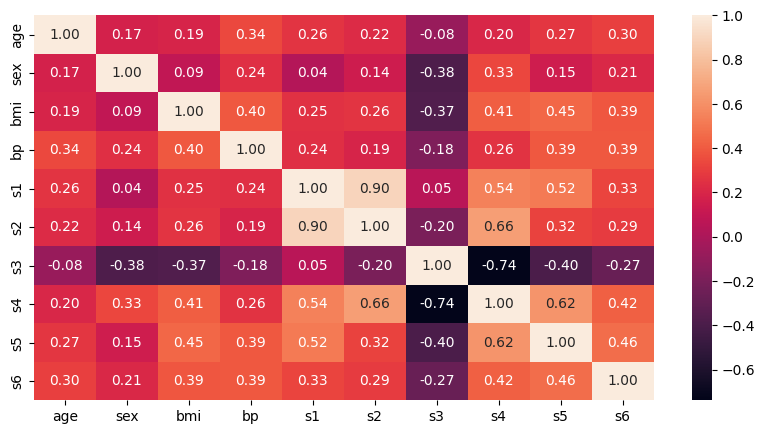

In [105]:
# Значения vif сильно уменьшились, но для некоторых параметров всё еще высоки. Посмотрим взаимную коррелляцию признаков

def print_heatmap(df):
  plt.figure(figsize=(10, 5))
  _ = sns.heatmap(df.corr(), annot=True, fmt='.2f')

print_heatmap(X_all)

age    1.216849
sex    1.275156
bmi    1.502873
bp     1.457600
s2     2.918392
s3     3.730392
s4     7.796345
s5     2.172225
s6     1.484307
dtype: float64


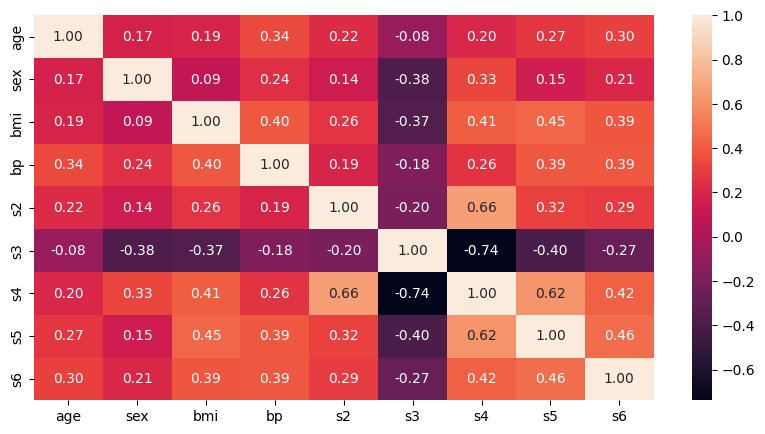

In [106]:
# Видно, что s1 и s2 сильно корреллированы. Попробуем убрать s1

tmp = X_all.drop(["s1"], axis=1)
printVIF(tmp)
print_heatmap(tmp)

age    1.216256
sex    1.269080
bmi    1.498939
bp     1.447290
s2     1.180785
s3     1.473844
s5     1.640887
s6     1.476687
dtype: float64


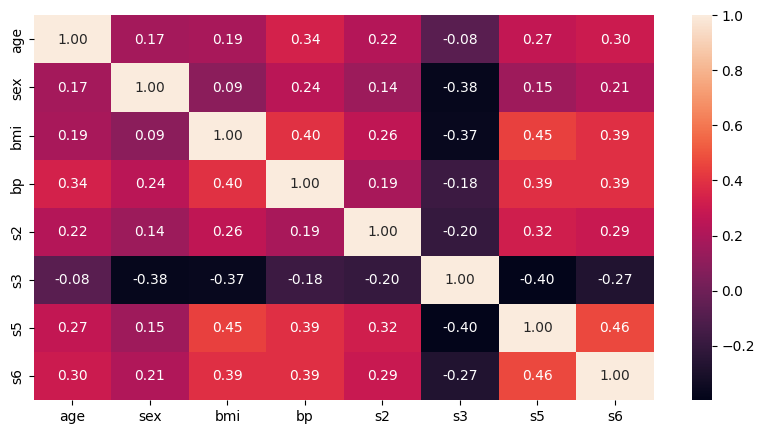

In [107]:
# Уберем s4

tmp = X_all.drop(["s1", "s4"], axis=1)
printVIF(tmp)
print_heatmap(tmp)

In [108]:
# Теперь все признаки имеют низкий vif и мы можем с ними работать

X = X_all.drop(["s1", "s4"], axis=1)

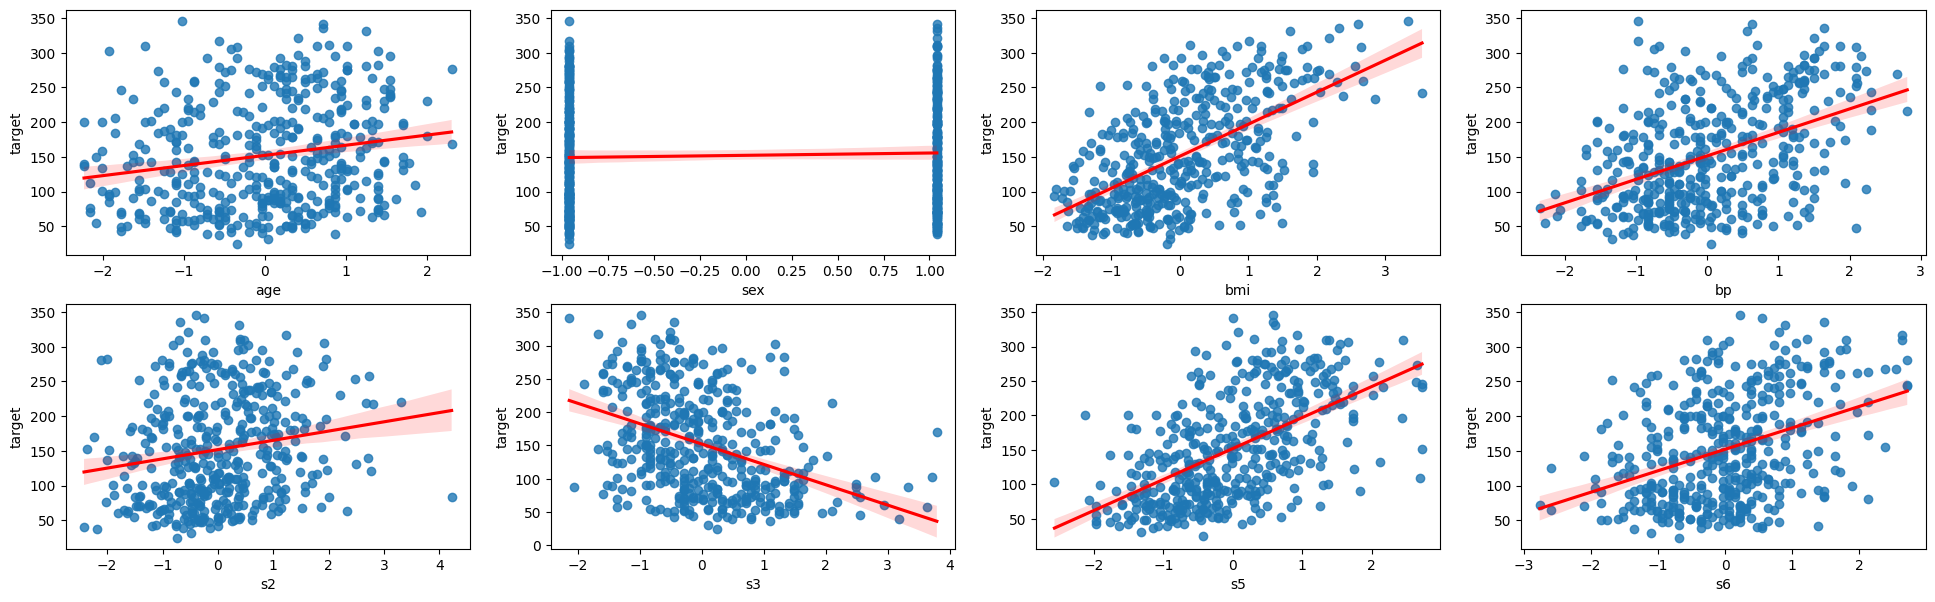

In [110]:
cols = 4
fig, axs = plt.subplots(ncols=cols, nrows=2, figsize=(24, 7))

Xy = X.join(y)
for i, val in enumerate(X.columns.values):
  sns.regplot(x=val, y='target', data=Xy, ax=axs[i // cols][i % cols], fit_reg=True, line_kws={"color": "red"})

# Линейная регрессия